# Part 2: Non-Stationary Bandit Algorithms


In [1]:
# import necessary libraries
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

In [2]:
def generate_gradual_drift_means(key, initial_means, n_steps, drift_std=0.01):
    """Generate gradually drifting means: μ_{i,t} = μ_{i,t-1} + ε_{i,t}"""
    k = len(initial_means)
    means_over_time = jnp.zeros((n_steps, k))
    means_over_time = means_over_time.at[0].set(initial_means)

    for t in range(1, n_steps):
        key, subkey = random.split(key)
        drift = random.normal(subkey, (k,)) * drift_std
        means_over_time = means_over_time.at[t].set(means_over_time[t - 1] + drift)

    return means_over_time


def generate_mean_reverting_means(
    key, initial_means, n_steps, kappa=0.5, noise_std=0.01
):
    """Generate mean-reverting means: μ_{i,t} = κμ_{i,t-1} + ε_{i,t}"""
    k = len(initial_means)
    means_over_time = jnp.zeros((n_steps, k))
    means_over_time = means_over_time.at[0].set(initial_means)

    for t in range(1, n_steps):
        key, subkey = random.split(key)
        noise = random.normal(subkey, (k,)) * noise_std
        means_over_time = means_over_time.at[t].set(
            kappa * means_over_time[t - 1] + noise
        )

    return means_over_time


def generate_abrupt_change_means(key, initial_means, n_steps, change_point=501):
    """Generate means with abrupt change at specified time point"""
    k = len(initial_means)
    means_over_time = jnp.zeros((n_steps, k))

    # First half: constant means
    for t in range(min(change_point, n_steps)):
        means_over_time = means_over_time.at[t].set(initial_means)

    # Second half: permuted means
    if change_point < n_steps:
        key, subkey = random.split(key)
        permuted_means = random.permutation(subkey, initial_means)
        for t in range(change_point, n_steps):
            means_over_time = means_over_time.at[t].set(permuted_means)

    return means_over_time, (
        random.permutation(random.split(key)[1], jnp.arange(k))
        if change_point < n_steps
        else None
    )

In [3]:
def epsilon_greedy_nonstationary(
    key, means_over_time, epsilon, step_size=None, n_steps=2000
):
    """
    Epsilon-greedy with exponential recency weighting for non-stationary environments
    If step_size is None, uses sample averaging (bad for non-stationary)
    If step_size is provided, uses exponential recency weighting (better for non-stationary)
    """
    k = means_over_time.shape[1]

    Q = jnp.zeros(k)
    action_counts = jnp.zeros(k)

    rewards = jnp.zeros(n_steps)
    optimal_actions = jnp.zeros(n_steps, dtype=bool)

    for step in range(n_steps):
        # Find optimal arm for this time step
        optimal_arm = jnp.argmax(means_over_time[step])

        key, subkey = random.split(key)

        # Epsilon-greedy action selection
        if random.uniform(subkey) < epsilon:
            key, subkey = random.split(key)
            chosen_arm = random.randint(subkey, (1,), 0, k)[0]
        else:
            max_q = jnp.max(Q)
            best_arms = jnp.where(Q == max_q)[0]
            key, subkey = random.split(key)
            chosen_arm = random.choice(subkey, best_arms)

        # Get reward
        key, subkey = random.split(key)
        reward = random.normal(subkey) + means_over_time[step, chosen_arm]

        # Update Q-value
        action_counts = action_counts.at[chosen_arm].add(1)

        if step_size is None:
            # Sample averaging (problematic for non-stationary)
            alpha = 1.0 / action_counts[chosen_arm]
        else:
            # Exponential recency weighting (better for non-stationary)
            alpha = step_size

        Q = Q.at[chosen_arm].add(alpha * (reward - Q[chosen_arm]))

        # Track results
        rewards = rewards.at[step].set(reward)
        optimal_actions = optimal_actions.at[step].set(chosen_arm == optimal_arm)

    return rewards, optimal_actions, Q


def epsilon_greedy_with_reset(
    key, means_over_time, epsilon, step_size=None, reset_point=501, n_steps=2000
):
    """Epsilon-greedy with hard reset at specified time point"""
    k = means_over_time.shape[1]

    Q = jnp.zeros(k)
    action_counts = jnp.zeros(k)

    rewards = jnp.zeros(n_steps)
    optimal_actions = jnp.zeros(n_steps, dtype=bool)

    for step in range(n_steps):
        # Hard reset at change point
        if step == reset_point:
            Q = jnp.zeros(k)
            action_counts = jnp.zeros(k)

        optimal_arm = jnp.argmax(means_over_time[step])

        key, subkey = random.split(key)

        # Epsilon-greedy action selection
        if random.uniform(subkey) < epsilon:
            key, subkey = random.split(key)
            chosen_arm = random.randint(subkey, (1,), 0, k)[0]
        else:
            max_q = jnp.max(Q)
            best_arms = jnp.where(Q == max_q)[0]
            key, subkey = random.split(key)
            chosen_arm = random.choice(subkey, best_arms)

        # Get reward
        key, subkey = random.split(key)
        reward = random.normal(subkey) + means_over_time[step, chosen_arm]

        # Update Q-value
        action_counts = action_counts.at[chosen_arm].add(1)

        if step_size is None:
            alpha = 1.0 / action_counts[chosen_arm]
        else:
            alpha = step_size

        Q = Q.at[chosen_arm].add(alpha * (reward - Q[chosen_arm]))

        rewards = rewards.at[step].set(reward)
        optimal_actions = optimal_actions.at[step].set(chosen_arm == optimal_arm)

    return rewards, optimal_actions, Q


def gradient_bandit_nonstationary(
    key, means_over_time, alpha, use_baseline=True, n_steps=2000
):
    """Gradient bandit for non-stationary environments"""
    k = means_over_time.shape[1]

    H = jnp.zeros(k)  # Action preferences

    rewards = jnp.zeros(n_steps)
    optimal_actions = jnp.zeros(n_steps, dtype=bool)

    # Running average reward (baseline) - could also use exponential average
    avg_reward = 0.0

    for step in range(n_steps):
        optimal_arm = jnp.argmax(means_over_time[step])

        key, subkey = random.split(key)

        # Softmax action selection
        H_stable = H - jnp.max(H)
        exp_H = jnp.exp(H_stable)
        action_probs = exp_H / jnp.sum(exp_H)

        chosen_arm = random.choice(subkey, k, p=action_probs)

        # Get reward
        key, subkey = random.split(key)
        reward = random.normal(subkey) + means_over_time[step, chosen_arm]

        # Update baseline
        if step == 0:
            avg_reward = reward
        else:
            # Could use exponential average: avg_reward = 0.9 * avg_reward + 0.1 * reward
            avg_reward = avg_reward + (reward - avg_reward) / (step + 1)

        # Gradient update
        if use_baseline:
            reward_diff = reward - avg_reward
        else:
            reward_diff = reward

        # Update preferences
        for a in range(k):
            if a == chosen_arm:
                H = H.at[a].add(alpha * reward_diff * (1 - action_probs[a]))
            else:
                H = H.at[a].add(-alpha * reward_diff * action_probs[a])

        rewards = rewards.at[step].set(reward)
        optimal_actions = optimal_actions.at[step].set(chosen_arm == optimal_arm)

    return rewards, optimal_actions, H

In [4]:
def compare_algorithms_nonstationary(
    key, initial_means, environment_type, n_simulations=100, n_steps=2000
):
    """Compare algorithms in non-stationary environment"""
    print(f"Running {environment_type} environment comparison...")

    algorithms = {
        "Eps-Greedy (Sample Avg)": lambda k, means: epsilon_greedy_nonstationary(
            k, means, 0.1, step_size=None
        ),
        "Eps-Greedy (alpha=0.1)": lambda k, means: epsilon_greedy_nonstationary(
            k, means, 0.1, step_size=0.1
        ),
        "Eps-Greedy (alpha=0.3)": lambda k, means: epsilon_greedy_nonstationary(
            k, means, 0.1, step_size=0.3
        ),
        "Gradient (alpha=0.1)": lambda k, means: gradient_bandit_nonstationary(
            k, means, 0.1
        ),
        "Gradient (alpha=0.4)": lambda k, means: gradient_bandit_nonstationary(
            k, means, 0.4
        ),
    }

    if environment_type == "abrupt":
        algorithms["Eps-Greedy (Reset)"] = lambda k, means: epsilon_greedy_with_reset(
            k, means, 0.1, step_size=0.1
        )

    results = {}

    for alg_name, alg_func in algorithms.items():
        print(f"  Running {alg_name}...")
        all_rewards = []
        all_optimal = []

        for sim in range(n_simulations):
            key, sim_key = random.split(key)

            # Generate environment
            if environment_type == "drift":
                means_over_time = generate_gradual_drift_means(
                    sim_key, initial_means, n_steps
                )
            elif environment_type == "mean_reverting":
                means_over_time = generate_mean_reverting_means(
                    sim_key, initial_means, n_steps
                )
            elif environment_type == "abrupt":
                means_over_time, _ = generate_abrupt_change_means(
                    sim_key, initial_means, n_steps
                )

            # Run algorithm
            key, alg_key = random.split(key)
            rewards, optimal_actions, _ = alg_func(alg_key, means_over_time)

            all_rewards.append(rewards)
            all_optimal.append(optimal_actions)

        # Average across simulations
        avg_rewards = jnp.mean(jnp.array(all_rewards), axis=0)
        avg_optimal = jnp.mean(jnp.array(all_optimal), axis=0) * 100

        results[alg_name] = {
            "avg_rewards": avg_rewards,
            "avg_optimal": avg_optimal,
            "final_reward": jnp.mean(avg_rewards[-100:]),
            "final_optimal": jnp.mean(avg_optimal[-100:]),
        }

    return results


def plot_nonstationary_comparison(results, environment_type, true_means):
    """Plot comparison of algorithms in non-stationary environment"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot average rewards
    for alg_name, result in results.items():
        ax1.plot(result["avg_rewards"], label=alg_name, linewidth=2)

    ax1.set_title(f"Average Reward - {environment_type.title()} Environment")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Average Reward")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot optimal action percentage
    for alg_name, result in results.items():
        ax2.plot(result["avg_optimal"], label=alg_name, linewidth=2)

    ax2.set_title(f"Optimal Action % - {environment_type.title()} Environment")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("% Optimal Action")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # summary
    print(f"\n{environment_type.upper()} ENVIRONMENT - FINAL PERFORMANCE:")
    print("=" * 60)
    for alg_name, result in results.items():
        print(
            f"{alg_name:25s}: Reward={result['final_reward']:.3f}, Optimal={result['final_optimal']:.1f}%"
        )

In [8]:
# Set up initial environment
key = random.PRNGKey(123)  # same seed as in notebook.ipynb (part 1)
key, subkey = random.split(key)

# used same initial means as in part 1
initial_means = random.normal(subkey, (10,))
print(f"Initial true means:\n {initial_means}")
print(
    f"\nInitial optimal arm: {jnp.argmax(initial_means)} (mean = {jnp.max(initial_means):.3f})"
)

Initial true means:
 [-0.5154414  -0.89756405  1.9826834  -1.9789759  -2.8818078  -0.662635
 -0.03326578 -0.1879544  -0.6107877   0.16164331]

Initial optimal arm: 2 (mean = 1.983)


Running drift environment comparison...
  Running Eps-Greedy (Sample Avg)...
  Running Eps-Greedy (alpha=0.1)...
  Running Eps-Greedy (alpha=0.3)...
  Running Gradient (alpha=0.1)...
  Running Gradient (alpha=0.4)...


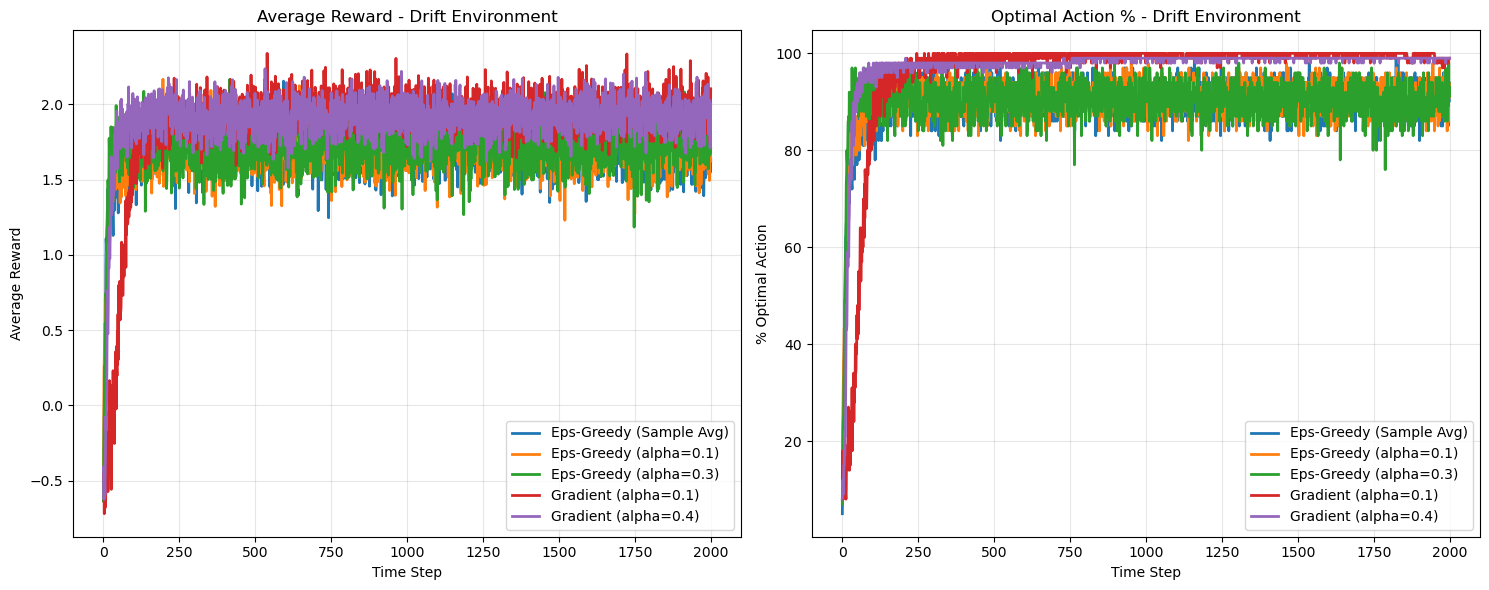


DRIFT ENVIRONMENT - FINAL PERFORMANCE:
Eps-Greedy (Sample Avg)  : Reward=1.661, Optimal=90.9%
Eps-Greedy (alpha=0.1)   : Reward=1.720, Optimal=90.9%
Eps-Greedy (alpha=0.3)   : Reward=1.764, Optimal=90.5%
Gradient (alpha=0.1)     : Reward=1.956, Optimal=99.2%
Gradient (alpha=0.4)     : Reward=1.911, Optimal=98.9%


Running mean_reverting environment comparison...
  Running Eps-Greedy (Sample Avg)...
  Running Eps-Greedy (alpha=0.1)...
  Running Eps-Greedy (alpha=0.3)...
  Running Gradient (alpha=0.1)...
  Running Gradient (alpha=0.4)...


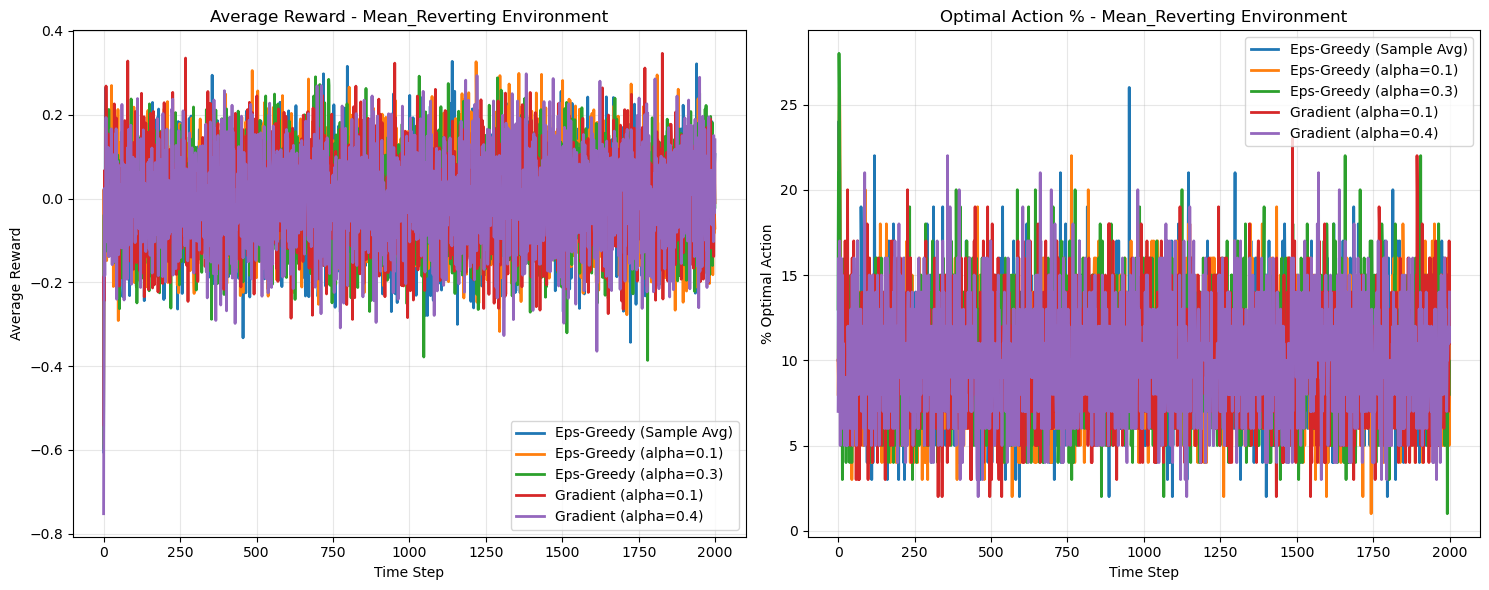


MEAN_REVERTING ENVIRONMENT - FINAL PERFORMANCE:
Eps-Greedy (Sample Avg)  : Reward=0.005, Optimal=9.7%
Eps-Greedy (alpha=0.1)   : Reward=-0.004, Optimal=10.6%
Eps-Greedy (alpha=0.3)   : Reward=0.012, Optimal=10.1%
Gradient (alpha=0.1)     : Reward=-0.019, Optimal=10.3%
Gradient (alpha=0.4)     : Reward=0.018, Optimal=9.6%


Running abrupt environment comparison...
  Running Eps-Greedy (Sample Avg)...
  Running Eps-Greedy (alpha=0.1)...
  Running Eps-Greedy (alpha=0.3)...
  Running Gradient (alpha=0.1)...
  Running Gradient (alpha=0.4)...
  Running Eps-Greedy (Reset)...


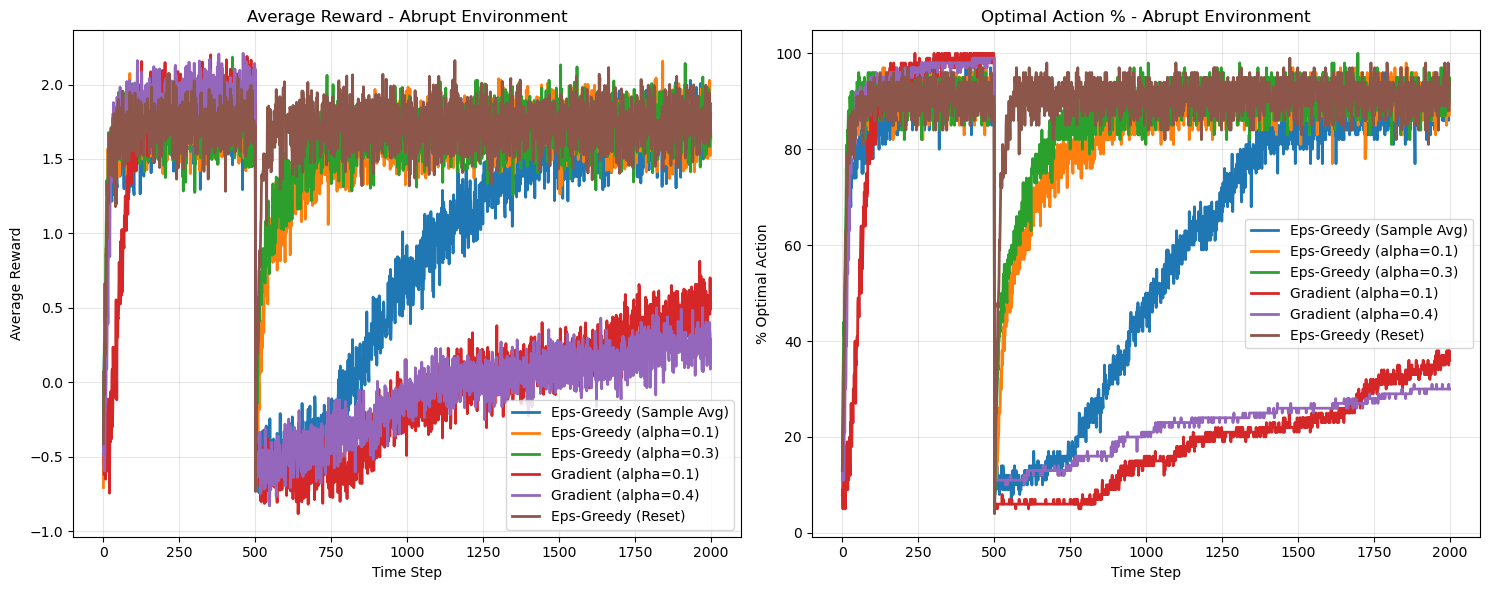


ABRUPT ENVIRONMENT - FINAL PERFORMANCE:
Eps-Greedy (Sample Avg)  : Reward=1.701, Optimal=89.2%
Eps-Greedy (alpha=0.1)   : Reward=1.706, Optimal=90.5%
Eps-Greedy (alpha=0.3)   : Reward=1.725, Optimal=90.9%
Gradient (alpha=0.1)     : Reward=0.481, Optimal=35.1%
Gradient (alpha=0.4)     : Reward=0.248, Optimal=30.0%
Eps-Greedy (Reset)       : Reward=1.745, Optimal=91.4%




In [9]:
# Test each environment type
environments = ["drift", "mean_reverting", "abrupt"]

for env_type in environments:
    key, subkey = random.split(key)
    results = compare_algorithms_nonstationary(
        subkey, initial_means, env_type, n_simulations=100
    )
    plot_nonstationary_comparison(results, env_type, initial_means)
    print("\n" + "=" * 80 + "\n")